# 1. Data and Pre-processing

## 1.1 Libraries

In [1]:
import cv2
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from timeit import default_timer as timer 
from going_modular.going_modular import utils, engine

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [34]:
import timm
import torch
import torchviz
from torch import nn
import torch.optim as optim
from torchinfo import summary
from torchsummary import summary as torchsummary
from torch.nn import functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import  plot_precision_recall_curve, plot_roc_curve
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from torchmetrics.classification import MulticlassAUROC

In [4]:
print(torch.__version__)
print(torch.cuda.get_device_name())

2.0.1+cu118
NVIDIA GeForce RTX 3060 Laptop GPU


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## 1.2.1 Data Set class examples

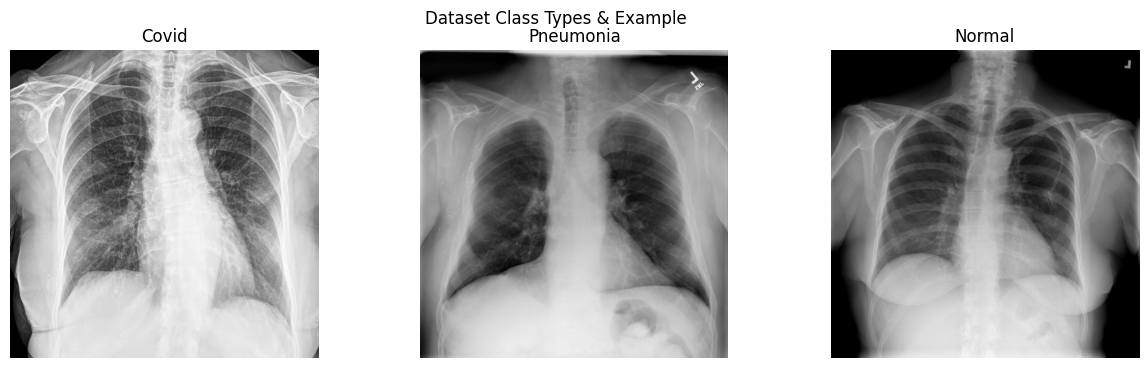

In [6]:
img1 = [f"data/train/covid/COVID-19 (2).png", 
        f"data/train/pneumonia/00000165_001.png",
        f"data/train/normal/00000005_003.png"]

fig = plt.figure(figsize = (15,4))

for i in range(0, 3):
    plt.subplot(1,3,i+1)
    plt.imshow(cv2.imread(img1[i]))
    plt.axis('off')

plt.subplot(1,3,1)
plt.title("Covid")

plt.subplot(1,3,2)
plt.title("Pneumonia")

plt.subplot(1,3,3)
plt.title("Normal")

plt.suptitle("Dataset Class Types & Example")
plt.show()

## 1.2.2 Dataset Loading

In [7]:
target_size = (224, 224)
batch_size = 20

In [8]:
transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
])

In [9]:
def idx_to_label(id):
    labels = {0: 'covid', 1: 'normal', 2: 'pneumonia'}
    return labels[id]

def label_to_idx(label):
    idx = {'covid': 0, 'normal': 1, 'pneumonia': 2}
    return idx[label]

def idx_to_onehot(idx):
    onehot = {0: [1,0,0], 1: [0,1,0], 2: [0,0,1]}
    return onehot[idx]

In [10]:
# Load the datasets
trainset = datasets.ImageFolder('data/train', 
                                transform=transform) 

valset = datasets.ImageFolder('data/val',
                                transform=transform) 

testset = datasets.ImageFolder('data/test', 
                               transform=transform)

In [11]:
# Create data loaders 
train_loader = DataLoader(trainset, 
                        batch_size=batch_size, 
                        shuffle=True,
                        num_workers=4, 
                        pin_memory=True)

val_loader = DataLoader(valset, 
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4, 
                        pin_memory=True)


test_loader = DataLoader(testset, 
                        batch_size=batch_size, 
                        shuffle=True,
                        num_workers=4, 
                        pin_memory=True)

In [12]:
print("Training Data:",len(train_loader)*batch_size)
print("Validation Data:",len(val_loader)*batch_size)
print("Testing Data:",len(test_loader)*batch_size)

Training Data: 9000
Validation Data: 540
Testing Data: 300


# Vision Transformers

In [13]:
class VisionTransformerBase(nn.Module):
    def __init__(self, num_classes):
        super(VisionTransformerBase, self).__init__()
        self.model = timm.create_model('vit_small_patch16_224', pretrained=True)
        for params in self.model.parameters():
            params.requires_grad = False
            
        self.model.head = nn.Sequential(
            nn.Linear(in_features=self.model.head.in_features, out_features=num_classes, bias = True)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [14]:
# Set the random seeds
torch.manual_seed(101)
torch.cuda.manual_seed(101)

In [15]:
grid_model = NeuralNetClassifier(
    module= VisionTransformerBase(num_classes=3)
)

print(grid_model.initialize())

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=VisionTransformerBase(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=384, out_features=1152, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=384, out_features=384, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
       

In [16]:
param_grid = {
    'optimizer__lr': [0.001, 0.01, 0.1],
    'optimizer': [optim.SGD, optim.RMSprop, optim.Adam, optim.Adadelta],
}

In [17]:
grid_len = int(len(train_loader)/2)

In [36]:
images = None
labels = None
for i in tqdm(range(grid_len)):
    images, labels = next(iter(train_loader))

100%|██████████| 225/225 [31:37<00:00,  8.43s/it]


In [37]:
grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, cv=5)
grid_result = grid.fit(images, labels)
torch.cuda.empty_cache()

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.7500           nan  3.1506
      2           nan       0.5000           nan  2.9309
      3           nan       0.5000           nan  2.9914
      4           nan       0.5000           nan  3.1550
      5           nan       0.5000           nan  2.9724
      6           nan       0.5000           nan  2.9780
      7           nan       0.5000           nan  2.9393
      8           nan       0.5000           nan  2.9502
      9           nan       0.5000           nan  3.1365
     10           nan       0.5000           nan  2.9685
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.5000           nan  3.0054
      2           nan       0.5000           nan  2.9509
      3           nan       0.7500           nan  2.8753
      4           nan       0.7

In [38]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

del images
del labels

Best: 0.550000 using {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.001}
0.550000 (0.100000) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.001}
0.400000 (0.122474) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.01}
0.350000 (0.122474) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.1}
0.500000 (0.000000) with: {'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'optimizer__lr': 0.001}
0.500000 (0.000000) with: {'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'optimizer__lr': 0.01}
0.500000 (0.000000) with: {'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'optimizer__lr': 0.1}
0.350000 (0.122474) with: {'optimizer': <class 'torch.optim.adam.Adam'>, 'optimizer__lr': 0.001}
0.400000 (0.122474) with: {'optimizer': <class 'torch.optim.adam.Adam'>, 'optimizer__lr': 0.01}
0.500000 (0.000000) with: {'optimizer': <class 'torch.optim.adam.Adam'>, 'optimizer__lr': 0.1}
0.500000 (0.000000) with: {'optimi

In [18]:
vit_model = VisionTransformerBase(num_classes=3).to(device)
# for param in vit_model.model[-2].parameters():
#     param.requires_grad_(False)

summary(model=vit_model, 
            input_size=(20, 3, 224, 224),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
VisionTransformerBase (VisionTransformerBase)      [20, 3, 224, 224]    [20, 3]              --                   Partial
├─VisionTransformer (model)                        [20, 3, 224, 224]    [20, 3]              76,032               Partial
│    └─PatchEmbed (patch_embed)                    [20, 3, 224, 224]    [20, 196, 384]       --                   False
│    │    └─Conv2d (proj)                          [20, 3, 224, 224]    [20, 384, 14, 14]    (295,296)            False
│    │    └─Identity (norm)                        [20, 196, 384]       [20, 196, 384]       --                   --
│    └─Dropout (pos_drop)                          [20, 197, 384]       [20, 197, 384]       --                   --
│    └─Identity (patch_drop)                       [20, 197, 384]       [20, 197, 384]       --                   --
│    └─Identity (norm_pre)               

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adadelta(vit_model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

In [20]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(dataloader), desc='Training', unit='batch') as progress_bar:
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update the progress bar
            progress_bar.set_postfix({'Loss': loss.item(), 'Acc': correct / total})
            progress_bar.update(1)

    train_loss = train_loss / len(dataloader.dataset)
    train_accuracy = correct / total

    return train_loss, train_accuracy

In [21]:
def validate(model, dataloader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad(), tqdm(total=len(dataloader), desc='Validation', unit='batch') as progress_bar:
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update the progress bar
            progress_bar.set_postfix({'Loss': loss.item(), 'Acc': correct / total})
            progress_bar.update(1)

    val_loss = val_loss / len(dataloader.dataset)
    val_accuracy = correct / total

    return val_loss, val_accuracy

In [22]:
best_val_loss = float('inf')
epochs = 10

In [23]:
torch.cuda.empty_cache()

# Create empty results dictionary
results = {"train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": []
}

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}:")
    train_loss, train_accuracy = train(vit_model, train_loader, criterion, optimizer)
    val_loss, val_accuracy = validate(vit_model, val_loader, criterion)

    scheduler.step(val_loss)

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_accuracy)
    results["val_loss"].append(val_loss)
    results["val_acc"].append(val_accuracy)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(vit_model.state_dict(), 'early_stopping/best_vit_base_model.pth')

torch.save(results, 'Objects/vit_base_results.pth')

torch.cuda.empty_cache()

Epoch 1/10:


Training:   0%|          | 0/450 [00:00<?, ?batch/s]

Validation: 100%|██████████| 27/27 [00:05<00:00,  4.61batch/s, Loss=0.843, Acc=0.611]


Epoch 2/10:


Validation: 100%|██████████| 27/27 [00:05<00:00,  5.21batch/s, Loss=0.576, Acc=0.691]


Epoch 3/10:


Validation: 100%|██████████| 27/27 [00:04<00:00,  6.28batch/s, Loss=0.564, Acc=0.715]


Epoch 4/10:


Validation: 100%|██████████| 27/27 [00:03<00:00,  6.82batch/s, Loss=0.659, Acc=0.733]


Epoch 5/10:


Validation: 100%|██████████| 27/27 [00:04<00:00,  6.48batch/s, Loss=0.781, Acc=0.761]


Epoch 6/10:


Validation: 100%|██████████| 27/27 [00:04<00:00,  5.95batch/s, Loss=0.593, Acc=0.77] 


Epoch 7/10:


Validation: 100%|██████████| 27/27 [00:04<00:00,  6.33batch/s, Loss=0.478, Acc=0.772]


Epoch 8/10:


Validation: 100%|██████████| 27/27 [00:04<00:00,  6.54batch/s, Loss=0.373, Acc=0.774]


Epoch 9/10:


Validation: 100%|██████████| 27/27 [00:04<00:00,  6.05batch/s, Loss=0.47, Acc=0.776] 


Epoch 10/10:


Validation: 100%|██████████| 27/27 [00:04<00:00,  6.16batch/s, Loss=0.394, Acc=0.774]


In [24]:
results = torch.load('Objects/vit_base_results.pth')

vit_model = VisionTransformerBase(num_classes=3).to(device)

vit_model.load_state_dict(torch.load('early_stopping/best_vit_base_model.pth'))
vit_model.eval()

VisionTransformerBase(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximat

In [25]:
# # Example input
# example_input = torch.rand(1, 3, 224, 224).to(device)

# # Forward pass
# y = vit_model(example_input)

# # Visualize forward graph
# torchviz.make_dot(y, params=dict(vit_model.named_parameters()))

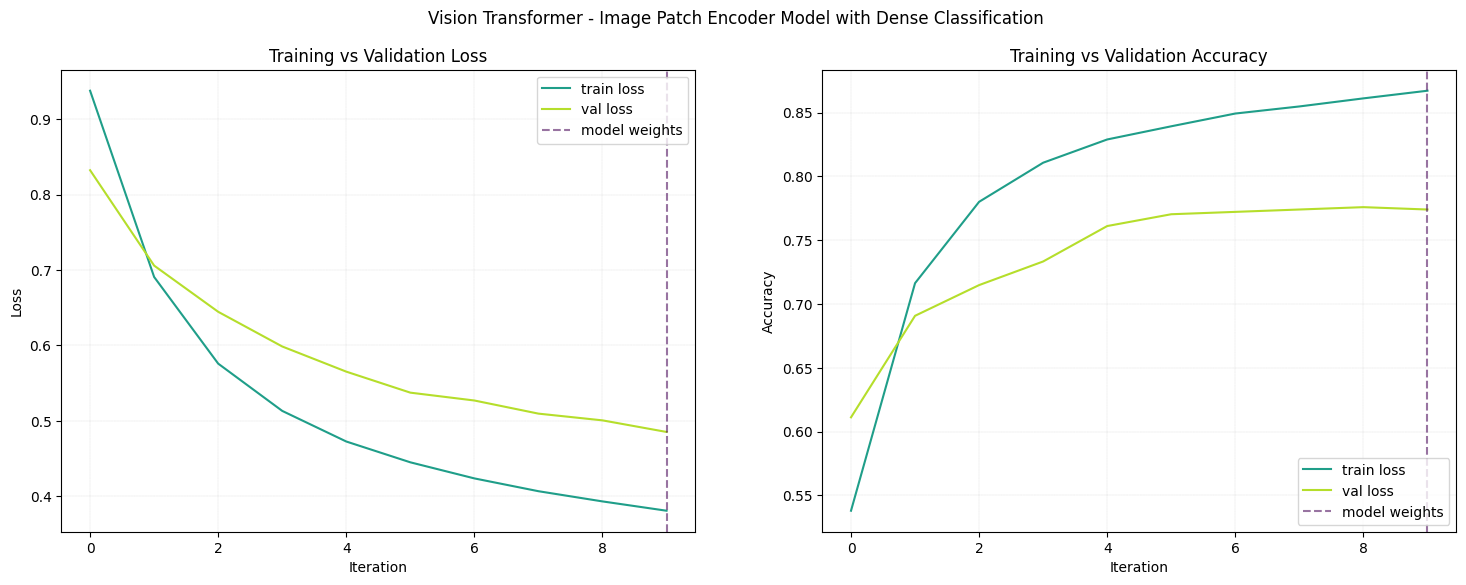

In [26]:
lowest = np.amin(results['val_loss'])
valloss_lowest = np.where(results['val_loss'] == lowest)

fig= plt.figure(figsize = (18, 6))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(results['train_loss'], color = '#1f9e89')
ax1.plot(results['val_loss'], color = '#b5de2b')
ax1.set_title('Training vs Validation Loss')
ax1.axvline(x = valloss_lowest, color = '#440154', 
                  linestyle = '--', alpha = 0.55)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Iteration')
ax1.grid(color = 'grey', linestyle = '--', linewidth = 0.1)
ax1.legend(['train loss', 
            'val loss', 
            'model weights'
            ], loc='upper right')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(results['train_acc'], color = '#1f9e89')
ax2.plot(results['val_acc'], color = '#b5de2b')
ax2.axvline(x = valloss_lowest, color = '#440154', 
                  linestyle = '--', alpha = 0.55)
ax2.set_title('Training vs Validation Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Iteration')
ax2.grid(color = 'grey', linestyle = '--', linewidth = 0.1)
ax2.legend(['train loss', 
            'val loss', 
            'model weights'
            ], loc='lower right')


plt.suptitle("Vision Transformer - Image Patch Encoder Model with Dense Classification")
plt.show()

In [27]:
predictions = []
y_test = []
for i, (images, labels) in enumerate(test_loader):
    with torch.inference_mode():
        predictions.append(vit_model(images.to(device)))
        y_test.append(labels)


predictions = torch.stack(predictions, dim = 0)
y_test = torch.stack(y_test, dim = 0)

In [28]:
y_pred = predictions.reshape(-1, 3)
y_test = y_test.reshape(-1)
y_pred= torch.argmax(y_pred, axis=1)

In [29]:
assert y_pred.shape == y_test.shape

In [30]:
print(classification_report(y_test.cpu(), y_pred.cpu()))

              precision    recall  f1-score   support

           0       0.80      0.72      0.76       100
           1       0.69      0.83      0.75       100
           2       0.98      0.88      0.93       100

    accuracy                           0.81       300
   macro avg       0.82      0.81      0.81       300
weighted avg       0.82      0.81      0.81       300



In [31]:
cm = confusion_matrix(y_test.cpu(), y_pred.cpu())
class_labels = ["covid", "normal", "pneumonia"]

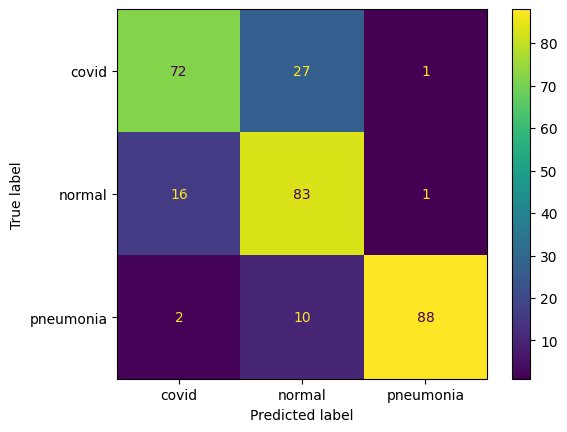

In [32]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot(cmap=plt.cm.viridis)
plt.show()

In [35]:
metric = MulticlassAUROC(num_classes=3, average="macro", thresholds=None)
metric(predictions.reshape(-1, 3).cpu(), y_test.cpu()) 

tensor(0.9315)